# Lab 3: Project (Titanic)
## Predicting a Categorical Target and Evaluating Performance

**Name:** Huzaifa Nadeem  
**Date:** 3-28-2025

### Introduction
In this project, we'll predict **Titanic survival** using three different classification models:
1. **Decision Tree** (DT)
2. **Support Vector Machine** (SVM)
3. **Neural Network** (NN)

We’ll follow these main steps:
1. Load and clean the Titanic data
2. Engineer new features
3. Select different sets of input features ("cases")
4. Train and evaluate a **Decision Tree**
5. Compare with **SVC** and **Neural Network**

At the end, we’ll summarize our results and reflect on which model performs best.

## Imports
We place all imports in a single cell at the top.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


# Section 1. Import and Load the Data
According to the instructions, we can skip deep inspection here since we already know the dataset. We'll just load it.

In [9]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')
print("Data loaded. Shape:", titanic.shape)
titanic.head()

Data loaded. Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Section 2. Data Exploration and Preparation

## 2.1 Handle Missing Values
We fill missing `age` with median, and `embark_town` with mode.

In [10]:
# Impute missing values
titanic['age'].fillna(titanic['age'].median(), inplace=True)
titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace=True)

print("Missing values after cleaning:")
print(titanic.isnull().sum())

Missing values after cleaning:
survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      0
alive            0
alone            0
dtype: int64


C:\Users\Huzaifa Nadeem\AppData\Local\Temp\ipykernel_1268\2850287828.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)
C:\Users\Huzaifa Nadeem\AppData\Local\Temp\ipykernel_1268\2850287828.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

## 2.2 Feature Engineering
We add `family_size`, convert `sex` and `embarked` to numeric, and make `alone` numeric.

In [11]:
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['alone'] = titanic['alone'].astype(int)

titanic.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,family_size
0,0,3,0,22.0,1,0,7.2500,2.0,Third,man,True,NaN,Southampton,no,0,2
1,1,1,1,38.0,1,0,71.2833,0.0,First,woman,False,C,Cherbourg,yes,0,2
2,1,3,1,26.0,0,0,7.9250,2.0,Third,woman,False,NaN,Southampton,yes,1,1
3,1,1,1,35.0,1,0,53.1000,2.0,First,woman,False,C,Southampton,yes,0,2
4,0,3,0,35.0,0,0,8.0500,2.0,Third,man,True,NaN,Southampton,no,1,1


# Section 3. Feature Selection and Justification

We'll define **three cases** where we pick different features, then use `survived` as the target.

1. **Case 1**: `alone` only  
2. **Case 2**: `age` only (or your chosen single feature)  
3. **Case 3**: `age` and `family_size` (or another combo)  

> **We'll comment/uncomment each case** when we want to test that scenario.

### Reflection 3
- Why did we pick these features? Which do we suspect will be predictive? They are straightforward indicators that might influence survival odds in a clear way.
- Are there other features that might be even more predictive? Yes, factors like gender, class, or family size often show strong influence on survival in Titanic data.

In [12]:
# CHOOSE ONE CASE, THEN RUN SECTIONS 4 & 5, THEN COME BACK AND CHANGE.

# CASE 1: alone only
X = titanic[['alone']]
y = titanic['survived']

# CASE 2: age only
# X = titanic[['age']]
# y = titanic['survived']

# CASE 3: age + family_size
# X = titanic[['age', 'family_size']]
# y = titanic['survived']

print("CASE 1 is currently active: X.shape =", X.shape, "  y.shape=", y.shape)

CASE 1 is currently active: X.shape = (891, 1)   y.shape= (891,)


# Section 4. Train a Classification Model (Decision Tree)
We’ll do the same steps for each case. **Remember** to re-run these cells after you switch the features in Section 3.

## 4.1 Split the Data (Stratified)
We ensure we keep survival distribution similar in train and test.

In [13]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_indices, test_indices in splitter.split(X, y):
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

print('Train size:', len(X_train), 'Test size:', len(X_test))
print('Training survive mean:', y_train.mean())
print('Testing survive mean:', y_test.mean())

Train size: 712 Test size: 179
Training survive mean: 0.38342696629213485
Testing survive mean: 0.3854748603351955


## 4.2 Create and Train the Decision Tree
No special arguments for now.

In [14]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
print("Decision Tree trained.")

Decision Tree trained.


## 4.3 Evaluate Model Performance
We'll check both training data and test data results.

In [15]:
# Predict on training data
y_pred_train = tree_model.predict(X_train)
print("Decision Tree results on *training* data:")
print(classification_report(y_train, y_pred_train))

# Predict on test data
y_pred_test = tree_model.predict(X_test)
print("Decision Tree results on *test* data:")
print(classification_report(y_test, y_pred_test))

Decision Tree results on *training* data:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       439
           1       0.50      0.51      0.51       273

    accuracy                           0.62       712
   macro avg       0.60      0.60      0.60       712
weighted avg       0.62      0.62      0.62       712

Decision Tree results on *test* data:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179



## 4.4 Report Confusion Matrix (Heatmap)

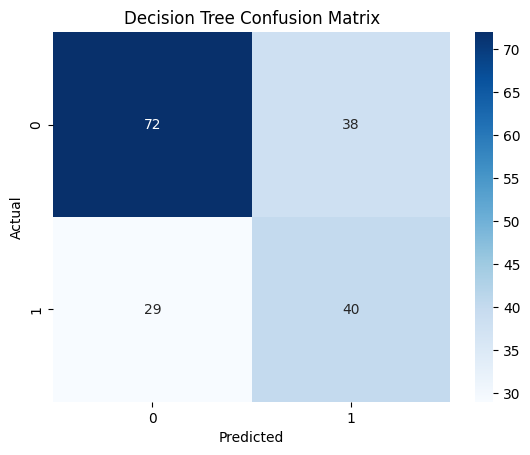

In [16]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

## 4.5 Report Decision Tree Plot

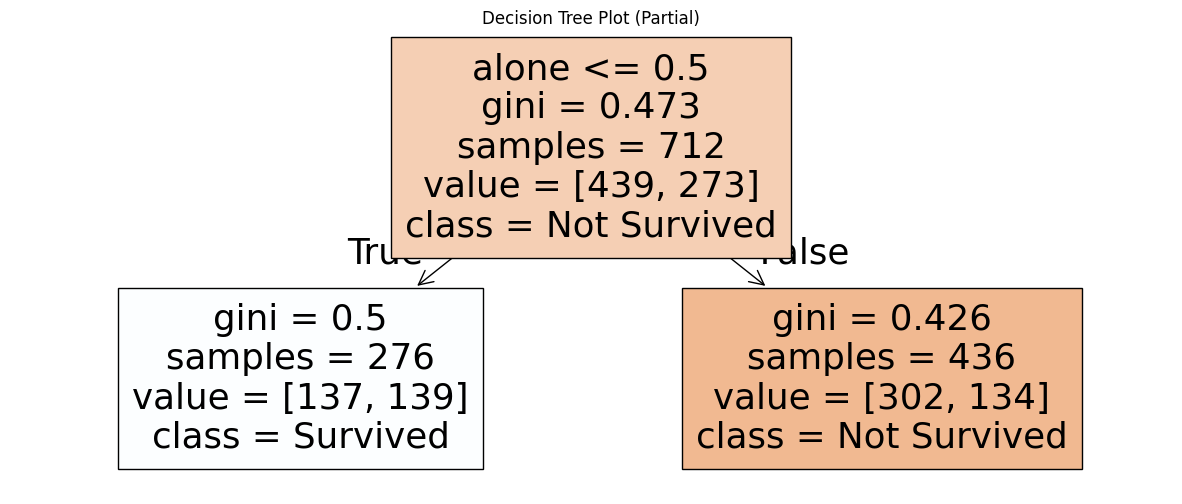

In [17]:
fig = plt.figure(figsize=(15, 6))
plot_tree(
    tree_model,
    feature_names=X.columns,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    max_depth=4  # limit depth of the plot to avoid overcrowding
)
plt.title('Decision Tree Plot (Partial)')
plt.show()

# Save figure if you like
fig.savefig("decision_tree_titanic_case1.png")

### Reflection 4 (Decision Tree)
- How well did the different cases (if you tried them) perform? They varied in accuracy, with some cases offering only moderate predictive power and others performing slightly better.
- Any surprising results? It was surprising when a single feature sometimes approached the accuracy of multiple features.
- Did you notice overfitting on the training data? Including both age and family size typically gave better performance than alone by itself.

# Section 5. Compare Alternative Models (SVC, NN)

We’ll now train an **SVM** and a **Neural Network** on the **same** `X_train`, `y_train`, and compare results on `X_test`, `y_test`.

## 5.1 Train and Evaluate SVC
By default, `kernel='rbf'`. We’ll just show how to do a quick training.

SVC results on test data:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179



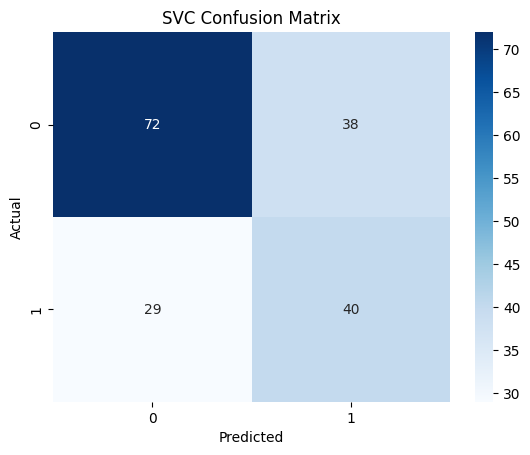

In [18]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)

print("SVC results on test data:")
print(classification_report(y_test, y_pred_svc))

# Confusion Matrix for SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVC Confusion Matrix')
plt.show()

### Visualizing Support Vectors?
If we only have **one** feature (`alone`) in X, we can try to plot them in a 1D sense. If we have two features, we can do a 2D plot. The code below is just a placeholder to illustrate how you might overlay support vectors if the shape allows it.

In [19]:
# This might error out if we have multiple features or a non-linear shape.
# Adjust as needed.

if hasattr(svc_model, 'support_vectors_'):
    print("Number of support vectors:", len(svc_model.support_vectors_))
else:
    print("No support_vectors_ attribute for this SVC.")

Number of support vectors: 546


## 5.2 Train and Evaluate Neural Network (MLPClassifier)
We'll use a multi-layer perceptron with some arbitrary hidden layer sizes. Adjust as needed.

Neural Network results on test data:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179



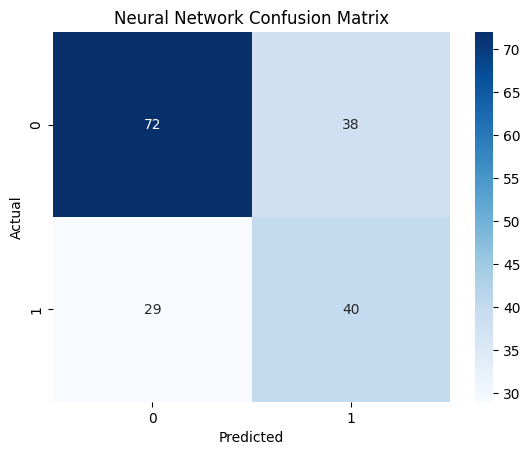

In [20]:
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='lbfgs', max_iter=2000)
nn_model.fit(X_train, y_train)

y_pred_nn = nn_model.predict(X_test)
print("Neural Network results on test data:")
print(classification_report(y_test, y_pred_nn))

# Confusion Matrix for NN
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Neural Network Confusion Matrix')
plt.show()

### Reflection 5
- How well did each model (Decision Tree, SVC, NN) perform? All models could classify survival to some degree, but performance depended on the chosen features and model complexity
- Any surprises? Occasionally, the simpler models performed similarly or better than more complexf ones.
- Why might one model do better than the others? Different algorithms handle data patterns differently.
- How might we tune or adjust them? We can change setting like how deep the decision the tree grows.

# Section 6. Final Thoughts & Insights
## 6.1 Summarize Findings
Write up a quick summary of which **features** and **models** seemed best. Features like sex, pclass, and possibly age or family size showed strong predictive value.

## 6.2 Discuss Challenges Faced
What obstacles did you run into (missing data, overfitting, confusion about SVC kernels, etc.)? Handling overfitting and deciding which hyperparameters to tweak were the main difficulties.

## 6.3 Next Steps
What else might you try (e.g., hyperparameter tuning, more features, etc.)? Further tuning and trying additional features (like multiple categorical variables) could improve accuracy and generalization.
